In [1]:
import os 
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import librosa

import tensorflow as tf

In [2]:
audio_folder_path= 'C:\\Users\\junsu\\Downloads\\audio'
list_word_folder= os.listdir(audio_folder_path)[1:]
list_word_folder

['bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'wow',
 'yes',
 'zero']

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11167863134238981988]

In [25]:
X=[]
Y= np.array([])
ver_speaker='012c8324' # 임의의 화자

for word in list_word_folder:
    word_path= audio_folder_path+'/'+word
    file_list= os.listdir(word_path) # wav 파일
    
    for file in file_list:
        file_path= word_path+'/'+file
        
        #피처 추출(tensorflow 사용)
        wav_loader= tf.io.read_file(file_path)
        audio, sr = tf.audio.decode_wav(wav_loader, desired_channels=1,
                                    desired_samples= 16000 ) # sample rate= 16000으로 설정
        waveform= tf.squeeze(audio, axis=-1)
        
        #stft로 스펙트로그램 값 저장 (short time fourier transform)
        spectrogram= tf.signal.stft(waveform, frame_length= 128,
                                   frame_step=128)
        
        # 차원이 맞지 않는 데이터는 삭제
        if spectrogram.shape==(125, 65):
            X.append(spectrogram)
            speaker= file[:8]
            if speaker==ver_speaker:
                Y= np.append(Y, 0)
            else:
                Y= np.append(Y, 1)
        else:
            pass
    print(f'### {word} end ###')

### bird end ###
### cat end ###
### dog end ###
### down end ###
### eight end ###
### five end ###
### four end ###
### go end ###
### happy end ###
### house end ###
### left end ###
### marvin end ###
### nine end ###
### no end ###
### off end ###
### on end ###
### one end ###
### right end ###
### seven end ###
### sheila end ###
### six end ###
### stop end ###
### three end ###
### tree end ###
### two end ###
### up end ###
### wow end ###
### yes end ###
### zero end ###


In [26]:
X=np.array(X)
X.shape

(63008, 125, 65)

In [27]:
Y.shape

(63008,)

In [44]:
from sklearn.model_selection import train_test_split
## 0.6: 0.2: 0.2 로 분리
## Stratifiy를 이용해서 데이터 불균형 해소
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size= 0.4, stratify= Y)


In [45]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(37804, 125, 65) (37804,)
(25204, 125, 65) (25204,)


In [46]:
X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, test_size=0.5, stratify= y_test)

In [47]:
## cnn 을 위해 차원 확장
train_X= np.expand_dims(X_train, -1)
val_X=np.expand_dims(X_val,-1)
test_X= np.expand_dims(X_test, -1)

In [50]:
from keras import models
from keras import layers
import keras
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


#Define Model
model = models.Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(125, 65,1)))
model.add(MaxPooling2D(pool_size= (2, 2)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

from keras.callbacks import EarlyStopping

# callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

history = model.fit(train_X,
                    y_train,
                    validation_data=(val_X, y_val),
                    callbacks=[es],
                    epochs=100)

Epoch 1/100
1182/1182 [==============================] - 311s 261ms/step - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/100
1182/1182 [==============================] - 303s 256ms/step - loss: 1.0315e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/100
1182/1182 [==============================] - 266s 225ms/step - loss: 1.6745e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/100
1182/1182 [==============================] - 240s 203ms/step - loss: 4.4709e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/100
1182/1182 [==============================] - 222s 188ms/step - loss: 1.9903e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/100
1182/1182 [==============================] - 223s 189ms/step - loss: 5.4217e-08 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/100
1182/1182 [==============================] - 223s 

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 123, 63, 64)       640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 61, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 59, 29, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 29, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 29, 14, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12992)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                4

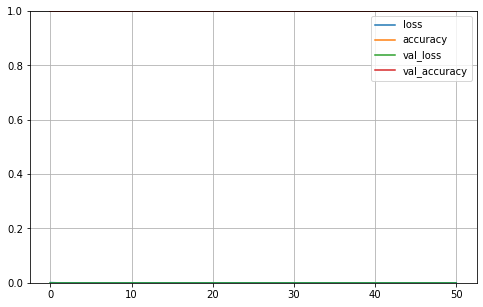

In [54]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [53]:
## Evaluate

test_loss, test_mae= model.evaluate(test_X, y_test)

394/394 [==============================] - 23s 59ms/step - loss: 0.0000e+00 - accuracy: 1.0000
